<a href="https://colab.research.google.com/github/EtzionR/LM4GeoAI/blob/main/Geo_LLM_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ex 3: Geo LLM Agents

### created by Etzion Harari | Geo-AI Course

[**https://github.com/EtzionR/LM4GeoAI**](https://github.com/EtzionR/LM4GeoAI)

In [166]:
!pip install cohere
!pip install osmnx

In [167]:
from difflib import get_close_matches
from getpass import getpass

import osmnx as ox
import folium
import cohere

Cohere models: [https://docs.cohere.com/docs/models#command](https://docs.cohere.com/docs/models#command)

Cohere MCP: [https://docs.cohere.com/page/basic-tool-use](https://docs.cohere.com/page/basic-tool-use)

In [168]:
MODEL  = "command-a-03-2025"
TEMP = .01

Get your Cohere API Key:

[https://dashboard.cohere.com/api-keys](https://dashboard.cohere.com/api-keys)

In [169]:
KEY = getpass("Please Enter COHERE KEY:\n")

len(KEY)

Please Enter COHERE KEY:
··········


40

In [170]:
client = cohere.Client(api_key=KEY)
client

In [171]:
QUERY = 'What is panda bear?'

output = client.chat(model=MODEL,
                     message=QUERY,
                     temperature=TEMP).text

print(output)

A panda bear, commonly referred to as a giant panda, is a species of bear native to central China. Scientifically known as *Ailuropoda melanoleuca*, it is easily recognized by its distinctive black and white coat, with black patches around the eyes, ears, and across its body. Giant pandas are primarily herbivorous, with bamboo making up the majority of their diet, although they do occasionally eat other plants, small animals, and fish.

Pandas are known for their solitary and peaceful nature. They spend much of their day eating, as they need to consume large amounts of bamboo to meet their nutritional needs due to their inefficient digestive system. Adult pandas can weigh between 70 to 125 kilograms (150 to 275 pounds) and are about 1.2 to 1.5 meters (4 to 5 feet) tall at the shoulder.

Giant pandas are an endangered species, with habitat loss and low birth rates being significant threats to their population. Conservation efforts, including breeding programs and habitat protection, hav

In [172]:
def get_pois_near_adress(location_adress, place_type, radius=500):
    """
    Load OSM POIs from given place_type

    :location_adress: location adress for searching OSM
    :place_type: type of point of interest (POI)
    :radius: radius around location_adress (in meters, int, default: 500)

    :return: selected dataframe
    """

    # Load data from OSM
    out = ox.features_from_address(location_adress, {"amenity": True}, radius)
    out = out[['name','amenity','geometry']]
    out = out.rename(columns={'amenity':'place_type'})

    # Find the closets place_type (using SequenceMatcher)
    place_type = get_close_matches(place_type,
                                   [*out.place_type.unique()],
                                   n=1,
                                   cutoff=.0)[0]

    # select the place_type
    dataframe = out[out.place_type==place_type]

    return dataframe

# ------------------------------------------------------------------------------


# get_place_info application:

location_adress = 'מגדלי הארבעה'
place_type      = 'fual'           # not fuel!

get_pois_near_adress(location_adress, place_type)

name place_type                   geometry
element id                                                        
node    339475532         פז       fuel  POINT (34.78253 32.06808)
        714371935       סד"ש       fuel  POINT (34.78319 32.06895)
        1823251323     סונול       fuel  POINT (34.78538 32.06639)
        4990104706  דור אלון       fuel   POINT (34.78719 32.0661)

In [173]:
system_prompt = """You are an AI assistant with access to the following tools:
get_pois_near_adress tool, which enable you to run osm query"""

tools = [
    {
        "name": "get_pois_near_adress",
        "description": "can return every type of geographic location near some given adress",
        "parameter_definitions": {
            "location_adress": {
                "description": "free text location adress",
                "type": "str",
                "required": True
            },
            "place_type": {
                "description": "type of point of interest (POI)",
                "type": "str",
                "required": True
            },
            "radius": {
                "description": "radius of search in meters",
                "type": "float",
                "required": False
            }
        }
    },
]

function_map = {get_pois_near_adress.__name__:get_pois_near_adress}
function_map

{'get_pois_near_adress': <function __main__.get_pois_near_adress(location_adress, place_type, radius=500)>}

In [174]:
tools

[{'name': 'get_pois_near_adress',
  'description': 'can return every type of geographic location near some given adress',
  'parameter_definitions': {'location_adress': {'description': 'free text location adress',
    'type': 'str',
    'required': True},
   'place_type': {'description': 'type of point of interest (POI)',
    'type': 'str',
    'required': True},
   'radius': {'description': 'radius of search in meters',
    'type': 'float',
    'required': False}}}]

In [175]:
HEB = 'מגדלי הארבעה'

user_prompt = f"I want you to return every cafe near {HEB}"


response = client.chat(
    model = MODEL,
    message = user_prompt,
    preamble = system_prompt,
    tools = tools
)

raw = response.text
print("MODEL RAW:", raw)

MODEL RAW: I will use the get_pois_near_adress tool to find cafes near מגדלי הארבעה.


In [176]:
response.tool_calls

[ToolCall(name='get_pois_near_adress', parameters={'location_adress': 'מגדלי הארבעה', 'place_type': 'cafe'})]

In [177]:
print(f'Citations = {response.citations}')

Citations = None


In [178]:
out = function_map[response.tool_calls[0].name](**response.tool_calls[0].parameters)
out

name place_type                   geometry
element id                                                             
node    553022802        קפה שרגא       cafe    POINT (34.7903 32.0707)
        635130301          משוגעת       cafe  POINT (34.78211 32.07238)
        1419068446        Arcaffe       cafe  POINT (34.78638 32.07048)
        1438109990         רולדין       cafe     POINT (34.782 32.0742)
        1450724665           מטרו       cafe  POINT (34.78436 32.06637)
        3465156312         רולדין       cafe  POINT (34.78693 32.07173)
        3731754512          ארומה       cafe  POINT (34.78587 32.07026)
        4587267164         Stampa       cafe  POINT (34.78248 32.07329)
        6005369587      Cafeteria       cafe  POINT (34.78438 32.06917)
        6389067485      Chop Chop       cafe   POINT (34.78199 32.0737)
        6644165508          Aroma       cafe  POINT (34.78769 32.07308)
        7211406506    Max Brenner       cafe   POINT (34.78677 32.0715)
        7524489151       דובנוב 8       cafe  POINT (34.78393 32.07444)
        9245806417         לנדוור       cafe  POINT (34.78636 32.07189)
        10279238209  מאפיית לחמים       cafe  POINT (34.78436 32.06964)
        10812416453        BEITEA       cafe  POINT (34.78798 32.07223)
        10948700190     LU coffee       cafe  POINT (34.79016 32.07017)
        11691761924  Greenkitchen       cafe  POINT (34.78354 32.06934)
        12032015683           mae       cafe  POINT (34.78829 32.07195)
        12050619149         ארומה       cafe   POINT (34.78341 32.0663)
        12139988888      קפה עוטף       cafe  POINT (34.78739 32.07308)
        12635329119        רולדין       cafe   POINT (34.79232 32.0743)
        13338979218          Biga       cafe  POINT (34.78691 32.07308)
        13339015829    Bagel Cafe       cafe  POINT (34.78529 32.07127)

In [179]:
fmap = folium.Map(location=[out.geometry.y.median(), out.geometry.x.median()],
                  zoom_start=15.5, width=500, height=500)

folium.GeoJson(out).add_to(fmap)

fmap

# -----------------------------------------------------------------------

In [ ]:


def get_path_from_a_to_b(adress_1, adress_2,  gap=.25):
    y1, x1 = ox.geocode(adress_1)
    y2, x2 = ox.geocode(adress_2)

    delta = max(abs(x1-x2)*gap, abs(y1-y2)*gap)
    bbox = [min(x1,x2)-delta, min(y1,y2)-delta, max(x1,x2)+delta, max(y1,y2)+delta]

    G = ox.graph.graph_from_bbox(bbox, truncate_by_edge =True, network_type ='drive', simplify =False)

    node1 = ox.distance.nearest_nodes(G, x1, y1)
    node2 = ox.distance.nearest_nodes(G, x2, y2)

    route = ox.routing.shortest_path(graph, orig=node1, dest=node2)
    route_xy = [(graph.nodes[osmid]['x'], graph.nodes[osmid]['y']) for osmid in route]
    return route_xy


ad1 = "כיכר המדינה תל אביב"

ad1 = "נמל יפו"
ad2 = 'תל אביב השלום'

ad1 = 'הכנסת'
ad2 = 'רחביה, ירושלים'


path = get_path_from_a_to_b(ad1, ad2)

path[:5]

In [ ]:

fmap = folium.Map(location=[np.array(path)[:,1].mean(), np.array(path)[:,0].mean()], zoom_start=13, width=500, height=500)

folium.PolyLine(
    locations=[(y,x) for x,y in path],
    color="blue",
    weight=5,
    tooltip="From Boston to San Francisco",
).add_to(fmap)

fmap

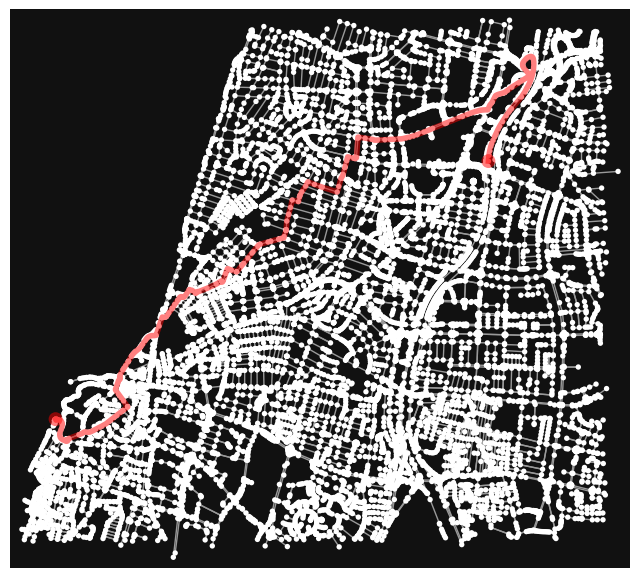

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [283]:
ox.plot.plot_graph_route(graph, route)